# 1. Basic AWS setup

In [1]:
import boto3, json, sagemaker, time
from sagemaker import get_execution_role

sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client("sagemaker-runtime")
sagemaker_session = sagemaker.Session(boto_session=boto3.Session())
role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


Map Triton Server Containers by Region

In [2]:
account_id_map = {
    "us-east-1": "785573368785",
    "us-east-2": "007439368137",
    "us-west-1": "710691900526",
    "us-west-2": "301217895009",
    "eu-west-1": "802834080501",
    "eu-west-2": "205493899709",
    "eu-west-3": "254080097072",
    "eu-north-1": "601324751636",
    "eu-south-1": "966458181534",
    "eu-central-1": "746233611703",
    "ap-east-1": "110948597952",
    "ap-south-1": "763008648453",
    "ap-northeast-1": "941853720454",
    "ap-northeast-2": "151534178276",
    "ap-southeast-1": "324986816169",
    "ap-southeast-2": "355873309152",
    "cn-northwest-1": "474822919863",
    "cn-north-1": "472730292857",
    "sa-east-1": "756306329178",
    "ca-central-1": "464438896020",
    "me-south-1": "836785723513",
    "af-south-1": "774647643957",
}

Start boto3 session

In [3]:
region = boto3.Session().region_name
if region not in account_id_map.keys():
    raise ("UNSUPPORTED REGION")

In [4]:
region

'us-east-1'

In [5]:
base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"
triton_image_uri = "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:21.08-py3".format(
    account_id=account_id_map[region], region=region, base=base
)

In [6]:
triton_image_uri

'785573368785.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tritonserver:21.08-py3'

# 2. Load Image

In [7]:
import numpy as np
from PIL import Image

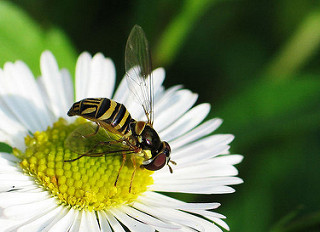

In [8]:
im = Image.open(r"img/daisy_bee.jpg")
im.show()

In [9]:
def get_sample_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))
    img = (np.array(img).astype(np.float32) / 255) - np.array(
        [0.485, 0.456, 0.406], dtype=np.float32
    ).reshape(1, 1, 3)
    img = img / np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1, 1, 3)
    img = np.transpose(img, (2, 0, 1))
    return img.tolist()

# 3. Prepare model package for Triton server

To deploy model on Triton Server, model folder should have a particular structure

<img src="img/folder_stru.jpg">

In [10]:
!mkdir -p triton-serve-pt/resnet/1/

In [12]:
configuration = """
name: "resnet"
platform: "pytorch_libtorch"
max_batch_size: 32
input [
 {
    name: "input__0"
    data_type: TYPE_FP32
    format: FORMAT_NCHW
    dims: [ 3, 224, 224 ]
  }
]
output {
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ 1000 ]
  }
"""

with open('triton-serve-pt/resnet/config.pbtxt', 'w') as file:
    file.write(configuration)

In [13]:
!tar -C triton-serve-pt/ -czf resnet/model.tar.gz resnet

# 4. Register the model in SageMaker Model repo

In [14]:
model_uri = sagemaker_session.upload_data(path="resnet/model.tar.gz", key_prefix="triton-serve-pt")

In [15]:
sm_model_name = "triton-resnet-pt-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

container = {
    "Image": triton_image_uri,
    "ModelDataUrl": model_uri,
    "Environment": {"SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "resnet"},
}

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-east-1:392055498132:model/triton-resnet-pt-2024-05-31-20-46-58


# 5. Create Endpoint Configuration

In [16]:
endpoint_config_name = "triton-resnet-pt-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.g4dn.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-east-1:392055498132:endpoint-config/triton-resnet-pt-2024-05-31-20-47-45


# 6. Deploy Endpoint

In [18]:
endpoint_name = "triton-resnet-pt-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_endpoint_response = sm_client.create_endpoint(
                                                     EndpointName=endpoint_name, 
                                                     EndpointConfigName=endpoint_config_name
                                                    )

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
cnt = 0
print(cnt,"Status: " + status)

while status == "Creating":
    cnt += 1
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print(cnt, "Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Endpoint Arn: arn:aws:sagemaker:us-east-1:392055498132:endpoint/triton-resnet-pt-2024-06-01-02-43-03
0 Status: Creating
1 Status: Creating
2 Status: Creating
3 Status: Creating
4 Status: Creating
5 Status: Creating
6 Status: Creating
7 Status: InService
Arn: arn:aws:sagemaker:us-east-1:392055498132:endpoint/triton-resnet-pt-2024-06-01-02-43-03
Status: InService


# 7. Invoke EndPoint with AWS Native Tools

7.1 Invoke endpoint

In [19]:
image_path = "img/daisy_bee.jpg"

payload = {
    "inputs": [
        {
            "name": "input__0",
            "shape": [1, 3, 224, 224],
            "datatype": "FP32",
            "data": get_sample_image(image_path),
        }
    ]
}

In [20]:
response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/octet-stream", Body=json.dumps(payload)
)

response_dict = json.loads(response["Body"].read().decode("utf8"))

7.2 Process endpoint response

In [21]:
print(response_dict)

{'model_name': 'resnet', 'model_version': '1', 'outputs': [{'name': 'output__0', 'datatype': 'FP32', 'shape': [1, 1000], 'data': [-1.315403699874878, 0.27412042021751404, -2.1095046997070312, -4.563088893890381, -3.524214267730713, -2.358008861541748, -2.8417012691497803, 3.1343588829040527, 1.8159303665161133, 0.13766993582248688, 2.876742124557495, 6.162403106689453, 2.2986154556274414, 1.7119640111923218, 4.269840717315674, 1.6338467597961426, 3.158191442489624, 1.4552812576293945, 1.2628153562545776, 3.709402322769165, 1.5173388719558716, 1.4855300188064575, 0.4640970528125763, 0.04401809722185135, 1.6519266366958618, 2.508178234100342, 1.5844099521636963, 1.4288349151611328, 2.8663482666015625, -0.14777272939682007, 3.1795623302459717, 6.124059677124023, 2.9312057495117188, -2.104152202606201, -1.3695988655090332, 1.0343762636184692, 3.342679500579834, 1.8124033212661743, 1.9676274061203003, 2.6843676567077637, 4.373420715332031, 2.5306859016418457, 0.47540488839149475, 0.14837524

In [22]:
resnet_predictions = response_dict['outputs'][0]['data']

In [23]:
with open('./imagenet-simple-labels.json') as file:
    labels = json.load(file)

In [24]:
print(labels[np.argmax(resnet_predictions)])

bee


# 8. Use Triton Client to talk to Endpoint

8.1 Install necessary Nvidia libs

In [25]:
!pip install nvidia-pyindex
!pip install tritonclient[http]

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


8.2 Define Helper functions to create HTTP request

In [26]:
import tritonclient.http as httpclient

def _get_sample_image_binary(input_name, output_name, image_path):
    inputs = []
    outputs = []
    inputs.append(httpclient.InferInput(input_name, [1, 3, 224, 224], "FP32"))
    input_data = np.array(get_sample_image(image_path), dtype=np.float32)
    input_data = np.expand_dims(input_data, axis=0)
    inputs[0].set_data_from_numpy(input_data, binary_data=True)
    outputs.append(httpclient.InferRequestedOutput(output_name, binary_data=True))
    request_body, header_length = httpclient.InferenceServerClient.generate_request_body(inputs, 
                                                                                         outputs=outputs)
    return request_body, header_length

def get_sample_image_binary_pt(image_path):
    return _get_sample_image_binary("input__0", "output__0", image_path)

8.3 Invoke Endpoint

In [28]:
image_path = "img/daisy_bee.jpg"
request_body, header_length = get_sample_image_binary_pt(image_path)

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/vnd.sagemaker-triton.binary+json;json-header-size={}".format(
        header_length
    ),
    Body=request_body,
)

8.4 Process Endpoint response

In [29]:
# Parse json header size length from the response
header_length_prefix = "application/vnd.sagemaker-triton.binary+json;json-header-size="
header_length_str = response["ContentType"][len(header_length_prefix) :]

# Read response body
result = httpclient.InferenceServerClient.parse_response_body(
    response["Body"].read(), header_length=int(header_length_str)
)

8.5 Extract and process ResNet50 prediction

In [30]:
resnet_prediction_via_triton_client = result.as_numpy("output__0")
print(resnet_prediction_via_triton_client)

[[-1.3154037e+00  2.7412042e-01 -2.1095047e+00 -4.5630889e+00
  -3.5242143e+00 -2.3580089e+00 -2.8417013e+00  3.1343589e+00
   1.8159304e+00  1.3766994e-01  2.8767421e+00  6.1624031e+00
   2.2986155e+00  1.7119640e+00  4.2698407e+00  1.6338468e+00
   3.1581914e+00  1.4552813e+00  1.2628154e+00  3.7094023e+00
   1.5173389e+00  1.4855300e+00  4.6409705e-01  4.4018097e-02
   1.6519266e+00  2.5081782e+00  1.5844100e+00  1.4288349e+00
   2.8663483e+00 -1.4777273e-01  3.1795623e+00  6.1240597e+00
   2.9312057e+00 -2.1041522e+00 -1.3695989e+00  1.0343763e+00
   3.3426795e+00  1.8124033e+00  1.9676274e+00  2.6843677e+00
   4.3734207e+00  2.5306859e+00  4.7540489e-01  1.4837524e-01
   2.0128477e+00 -9.3592930e-01  5.3426991e+00  2.0228717e+00
  -2.1631444e+00 -6.8201232e-01 -1.0119270e+00 -1.0649191e+00
   1.3263595e+00  4.5133362e+00  6.2500954e-01  2.7675471e+00
   1.8580374e+00  1.7469945e+00  3.0294504e+00  4.2896652e+00
   2.3591835e+00  5.1306464e-02 -5.0087146e-02 -1.5902115e-01
   1.773

In [31]:
with open('./imagenet-simple-labels.json') as file:
    labels = json.load(file)

In [32]:
print(labels[np.argmax(resnet_prediction_via_triton_client)])

bee


# 9. Terminate Endpoint and Cleanup

In [33]:
sm_client.delete_model(ModelName=sm_model_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '7dd5d70e-53ab-48b8-8eb3-d882228b30f2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7dd5d70e-53ab-48b8-8eb3-d882228b30f2',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 01 Jun 2024 02:59:15 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}